# Use astroML data to clasify QSOs and normal galaxies

In [1]:
%matplotlib notebook
import astroML
from astroML.datasets import sdss_corrected_spectra
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Use pre-computed PCA to reconstruct spectra
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra(data_home = './')
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data) 

In [2]:
print(data['log_OIII_Hb'].shape)
print(data['lineindex_cln'].shape)

(4000,)
(4000,)


In [3]:
i = np.where( (data['lineindex_cln'] == 4) | (data['lineindex_cln'] == 5 ) )
#i = np.where( data['lineindex_cln'] > -10 )
data_df = pd.DataFrame()
data_df['Target'] = data['lineindex_cln'][i]
data_df['log_NII_Ha'] = data['log_NII_Ha'][i]
data_df['log_OIII_Hb'] = data['log_OIII_Hb'][i]
data_df['redshift'] = data['z'][i]
data_df['Target'] = data_df['Target'].replace(4,0)
data_df['Target'] = data_df['Target'].replace(5,1)
feature_names = data_df.columns[1:]
#data_df['log_OIII_Hb'] = data_df.replace(np.inf, np.nan)
#data_df = data_df.dropna()
data_df = data_df[~data_df.isin([np.nan, np.inf, -np.inf]).any(1)]
data_df = data_df.reset_index(drop=True)
data_df.head()

,Target,log_NII_Ha,log_OIII_Hb,redshift
0,0,-0.968288,0.484500,0.006325
1,1,0.048296,0.106707,0.048089
2,0,-0.208011,-0.398189,0.065066
3,0,-0.157676,-0.342337,0.064857
4,0,-0.237583,0.031554,0.114681


In [4]:
feature_names

Index(['log_NII_Ha', 'log_OIII_Hb', 'redshift'], dtype='object')

In [5]:
data_df.shape

(1431, 4)

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 4 columns):
Target         1431 non-null int32
log_NII_Ha     1431 non-null float32
log_OIII_Hb    1431 non-null float32
redshift       1431 non-null float32
dtypes: float32(3), int32(1)
memory usage: 22.4 KB


In [7]:
class_0 = np.where(data_df.Target == 0)
class_1 = np.where(data_df.Target == 1)
print ("Galaxies =", class_0[0].size)
print ("QSOs = ", class_1[0].size)

Galaxies = 1275
QSOs =  156


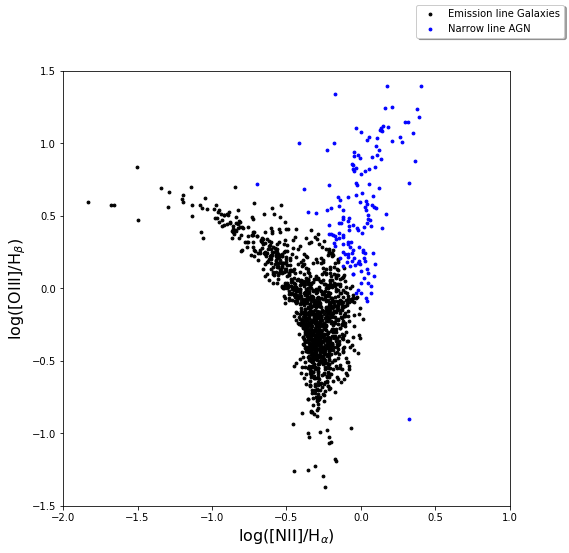

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
#ax.grid(False)
ax.scatter(data_df['log_NII_Ha'][class_0[0]], data_df['log_OIII_Hb'][class_0[0]], c='k', s=8, label = 'Emission line Galaxies')
ax.scatter(data_df['log_NII_Ha'][class_1[0]], data_df['log_OIII_Hb'][class_1[0]], c='b', s=8, label = 'Narrow line AGN')

ax.set_xlim(-2,1)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel(r'log([NII]/H$_\alpha$)', fontsize=16)
ax.set_ylabel(r'log([OIII]/H$_\beta$)', fontsize=16)
fig.legend(loc='upper right', fancybox = True, shadow = True)
plt.show()
#plt.savefig("bpt.png")

In [9]:
# Make X, y 
X = data_df[feature_names]
X_2d = data_df[['log_NII_Ha', 'log_OIII_Hb']]
y = data_df['Target']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, random_state=0)

## KNN


In [11]:
from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors = 5)
#knn.fit(X_train, y_train)
#knn.score(X_test, y_test)
fts = [r'log([NII]/H$_\alpha$)', r'log([OIII]/H$_\beta$)']
lbs = ['Galaxies', 'QSOs']
lims = [-2, 1, -1.5, 1.5]
lims = np.array(lims)

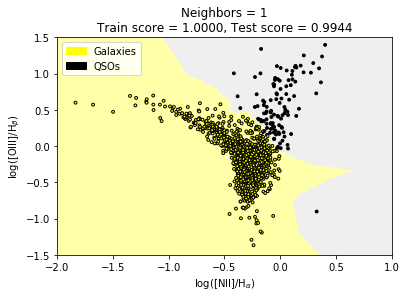

In [12]:
from adspy_shared_utilities import plot_two_class_knn

plot_two_class_knn(X_train.values, y_train.values, 1, 'uniform', 
                   X_test.values, y_test.values, [-2, 1, -1.5, 1.5], 8, fts, lbs)

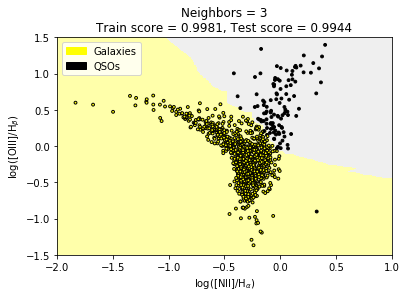

In [13]:
plot_two_class_knn(X_train.values, y_train.values, 3, 'uniform', 
                    X_test.values, y_test.values, [-2, 1, -1.5, 1.5], 8, fts, lbs)

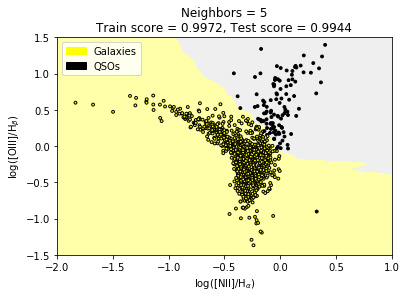

In [14]:
plot_two_class_knn(X_train.values, y_train.values, 5, 'uniform', 
                   X_test.values, y_test.values, [-2, 1, -1.5, 1.5], 8, fts, lbs)

# SVM

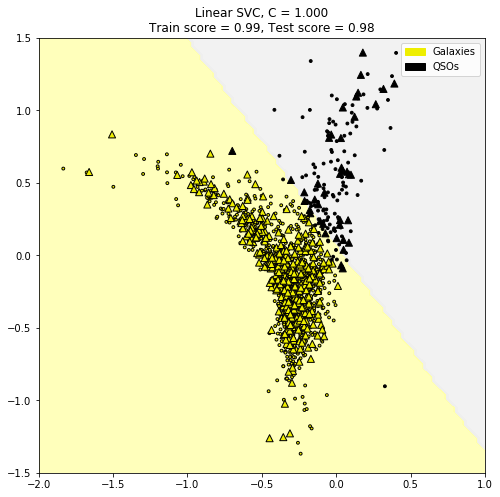

In [15]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
# The default SVC kernel is radial basis function (RBF)


fig, subaxes = plt.subplots(1, 1, figsize=(8, 8))
this_C = 1.0
clf = SVC(kernel = 'linear', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train.values, y_train.values, 
                                          X_test.values, y_test.values, title,
                                          subaxes, lims, 8, 
                                          target_names = lbs, plot_decision_regions = True)

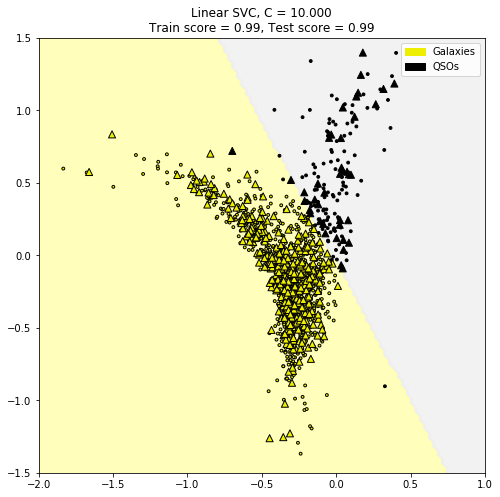

In [16]:
fig, subaxes = plt.subplots(1, 1, figsize=(8, 8))
this_C = 10.0
clf = SVC(kernel = 'linear', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train.values, y_train.values, 
                                          X_test.values, y_test.values, title,
                                          subaxes, lims, 8, 
                                          target_names = lbs, plot_decision_regions = True)

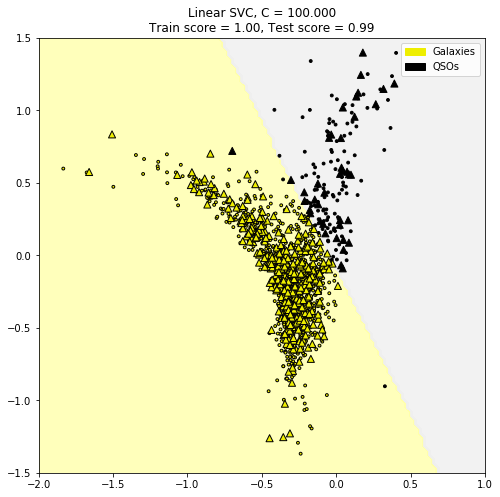

In [17]:
fig, subaxes = plt.subplots(1, 1, figsize=(8, 8))
this_C = 100.0
clf = SVC(kernel = 'linear', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train.values, y_train.values, 
                                          X_test.values, y_test.values, title,
                                          subaxes, lims, 8, 
                                          target_names = lbs, plot_decision_regions = True)

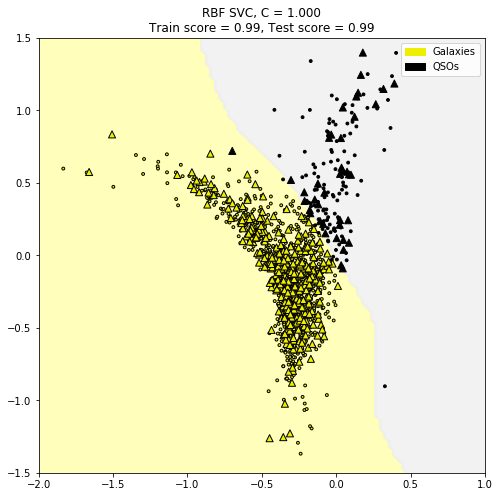

In [18]:
fig, subaxes = plt.subplots(1, 1, figsize=(8, 8))
this_C = 1.0
clf = SVC(kernel = 'rbf', C=this_C).fit(X_train, y_train)
title = 'RBF SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train.values, y_train.values, 
                                          X_test.values, y_test.values, title,
                                          subaxes, lims, 8, 
                                          target_names = lbs, plot_decision_regions = True)

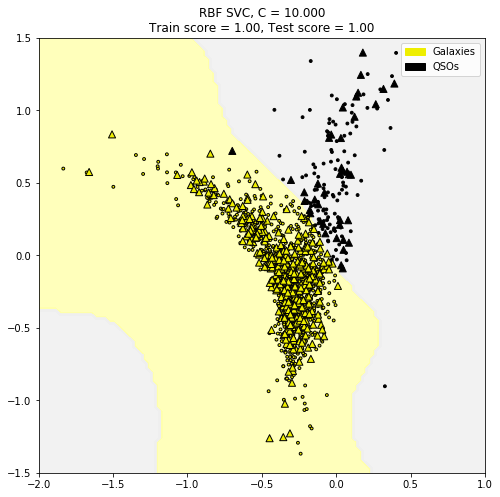

In [19]:
fig, subaxes = plt.subplots(1, 1, figsize=(8, 8))
this_C = 10.0
clf = SVC(kernel = 'rbf', C=this_C).fit(X_train, y_train)
title = 'RBF SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train.values, y_train.values, 
                                          X_test.values, y_test.values, title,
                                          subaxes, lims, 8, 
                                          target_names = lbs, plot_decision_regions = True)

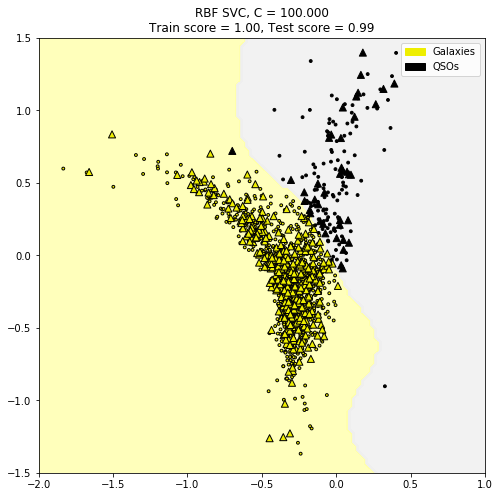

In [20]:
fig, subaxes = plt.subplots(1, 1, figsize=(8, 8))
this_C = 100.0
clf = SVC(kernel = 'rbf', C=this_C).fit(X_train, y_train)
title = 'RBF SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train.values, y_train.values, 
                                          X_test.values, y_test.values, title,
                                          subaxes, lims, 8, 
                                          target_names = lbs, plot_decision_regions = True)